In [21]:
pip install torch torchvision


Note: you may need to restart the kernel to use updated packages.


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)  # 2 classes (clean and dirty)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label


In [25]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [26]:
import os
import cv2
import numpy as np

In [27]:
def load_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(directory, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img)
            labels.append(label)
    return images, labels

In [28]:
clean_images, clean_labels = load_images("cleaned", label=0)
dirty_images, dirty_labels = load_images("polluted", label=1)


In [29]:
all_images = clean_images + dirty_images
all_labels = clean_labels + dirty_labels

In [30]:
X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)


In [31]:
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)


In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [33]:
model = CNNModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [34]:
num_epochs = 10

In [35]:
history = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total
    val_loss /= len(test_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Save history
    history.append({'train_loss': train_loss, 'val_loss': val_loss, 'val_acc': accuracy})


Epoch 1/10, Training Loss: 3.0046, Validation Loss: 0.2621, Accuracy: 0.8571
Epoch 2/10, Training Loss: 1.8801, Validation Loss: 0.1967, Accuracy: 0.9643
Epoch 3/10, Training Loss: 1.8972, Validation Loss: 0.1591, Accuracy: 0.9643
Epoch 4/10, Training Loss: 1.7717, Validation Loss: 0.2222, Accuracy: 0.9107
Epoch 5/10, Training Loss: 1.6330, Validation Loss: 0.1876, Accuracy: 0.9821
Epoch 6/10, Training Loss: 1.6219, Validation Loss: 0.1094, Accuracy: 0.9821
Epoch 7/10, Training Loss: 1.4722, Validation Loss: 0.1085, Accuracy: 0.9821
Epoch 8/10, Training Loss: 1.3521, Validation Loss: 0.1204, Accuracy: 0.9821
Epoch 9/10, Training Loss: 1.1342, Validation Loss: 0.1034, Accuracy: 0.9821
Epoch 10/10, Training Loss: 0.9681, Validation Loss: 0.0975, Accuracy: 0.9821


In [36]:
test_image = cv2.imread("/Users/pranaymishra/Desktop/ml_practice/ocean_dataset/cleaned/3.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = transform(test_image).unsqueeze(0)

model.eval()
with torch.no_grad():
    output = model(test_image)
    _, predicted_class = torch.max(output, 1)

print(f"The image is predicted to be {'clean' if predicted_class.item() == 0 else 'dirty'}.")

The image is predicted to be clean.


In [37]:
import matplotlib.pyplot as plt
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')


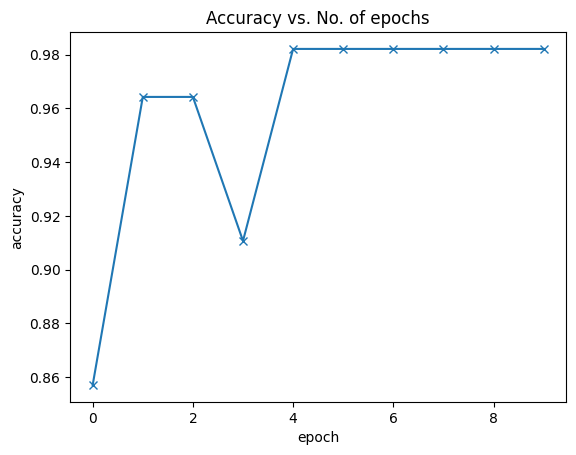

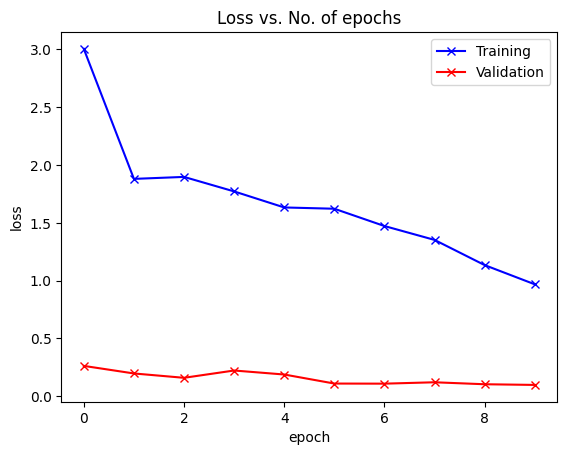

In [38]:
plot_accuracies(history)
plt.show()

plot_losses(history)
plt.show()